In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from warnings import filterwarnings
filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10
)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
train = pd.read_csv('train.csv', verbose=True, index_col='id')

Tokenization took: 372.88 ms
Type conversion took: 212.53 ms
Parser memory cleanup took: 0.02 ms
Tokenization took: 34.98 ms
Type conversion took: 58.49 ms
Parser memory cleanup took: 0.02 ms


In [3]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
train.tail()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,,,,,,,,,
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8
74050,I,0.9125,0.6750,0.2000,5.386405,2.055339,1.034757,1.700970,6


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74051 entries, 0 to 74050
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             74051 non-null  object 
 1   Length          74051 non-null  float64
 2   Diameter        74051 non-null  float64
 3   Height          74051 non-null  float64
 4   Weight          74051 non-null  float64
 5   Shucked Weight  74051 non-null  float64
 6   Viscera Weight  74051 non-null  float64
 7   Shell Weight    74051 non-null  float64
 8   Age             74051 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.6+ MB


In [6]:
train.shape

(74051, 9)

In [7]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Sex,74051,3,M,27084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,74051.0,NaN,NaN,NaN,1.31746,0.287757,0.1875,1.15,1.375,1.5375,2.012815
Diameter,74051.0,NaN,NaN,NaN,1.024496,0.237396,0.1375,0.8875,1.075,1.2,1.6125
Height,74051.0,NaN,NaN,NaN,0.348089,0.092034,0.0,0.3,0.3625,0.4125,2.825
Weight,74051.0,NaN,NaN,NaN,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.0,NaN,NaN,NaN,10.10427,5.618025,0.028349,5.712424,9.90815,14.033003,42.184056
Viscera Weight,74051.0,NaN,NaN,NaN,5.058386,2.792729,0.042524,2.8633,4.989512,6.988152,21.54562
Shell Weight,74051.0,NaN,NaN,NaN,6.72387,3.584372,0.042524,3.96893,6.931453,9.07184,28.491248
Age,74051.0,NaN,NaN,NaN,9.967806,3.175189,1.0,8.0,10.0,11.0,29.0


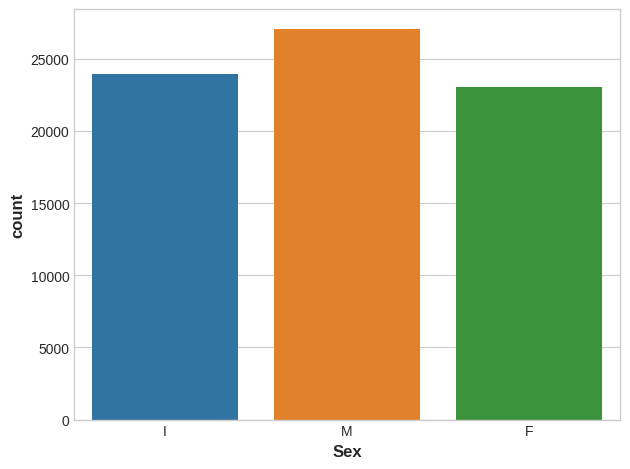

In [8]:
sns.countplot(x='Sex', data=train)
plt.show()

In [9]:
px.box(data_frame=train, x='Age', y='Sex')

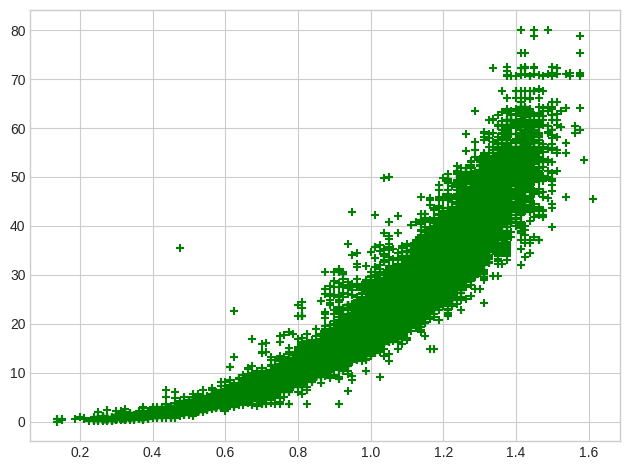

In [10]:
plt.scatter(x='Diameter', y='Weight', data=train, c='g', marker='+')
plt.show()

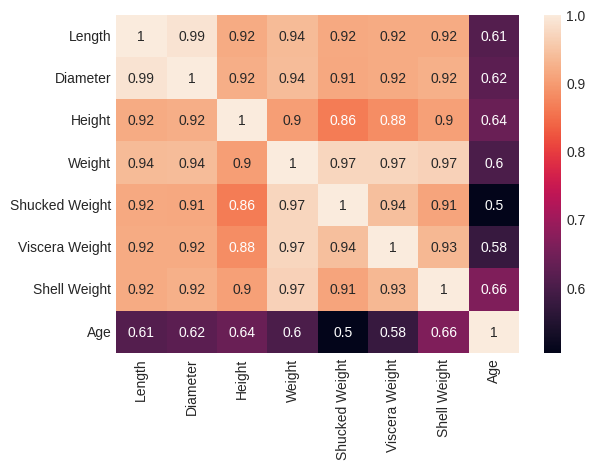

In [11]:
corr = train.corr()
sns.heatmap(corr, annot=True,)
plt.show()

Most of the features are linearly correlated

### Feature engineering

In [12]:
train['Lenght/Weight'] = train['Length'] / train['Weight']
train['Weight__sqrt'] = train['Weight'] ** 2
train['Height/Weight'] = train['Height'] / train['Weight']
train['Diameter_red'] = (train['Diameter'] * 0.5) * 5
train['Weight_sum'] = np.sum(train[['Shucked Weight', 'Viscera Weight', 'Shell Weight']], axis=1)
train['Length_sqrt'] = train['Length'] ** 2

In [13]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Lenght/Weight,Weight__sqrt,Height/Weight,Diameter_red,Weight_sum,Length_sqrt
id,,,,,,,,,,,,,,,
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.052635,839.445681,0.012943,2.93750,27.725811,2.325625
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.105582,108.543918,0.026396,2.06250,10.248344,1.210000
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.055998,613.922673,0.015135,2.78125,23.558434,1.925156
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,0.033557,2566.491985,0.009870,3.53125,46.343665,2.890000
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.053673,542.382845,0.014492,2.53125,22.438629,1.562500


In [14]:
encoder = LabelEncoder()
train['Sex'] = encoder.fit_transform(train['Sex'])

In [15]:
train.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age', 'Lenght/Weight',
       'Weight__sqrt', 'Height/Weight', 'Diameter_red', 'Weight_sum',
       'Length_sqrt'],
      dtype='object')

In [16]:
train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Sex,74051.0,1.055016,0.820647,0.000000,0.000000,1.000000,2.000000,2.000000
Length,74051.0,1.317460,0.287757,0.187500,1.150000,1.375000,1.537500,2.012815
Diameter,74051.0,1.024496,0.237396,0.137500,0.887500,1.075000,1.200000,1.612500
Height,74051.0,0.348089,0.092034,0.000000,0.300000,0.362500,0.412500,2.825000
Weight,74051.0,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.0,10.104270,5.618025,0.028349,5.712424,9.908150,14.033003,42.184056
Viscera Weight,74051.0,5.058386,2.792729,0.042524,2.863300,4.989512,6.988152,21.545620
Shell Weight,74051.0,6.723870,3.584372,0.042524,3.968930,6.931453,9.071840,28.491248
Age,74051.0,9.967806,3.175189,1.000000,8.000000,10.000000,11.000000,29.000000
Lenght/Weight,74051.0,0.084187,0.084138,0.017947,0.047235,0.058411,0.086217,3.306937


In [17]:
train.var()

Sex                    0.673462
Length                 0.082804
Diameter               0.056357
Height                 0.008470
Weight               159.975774
Shucked Weight        31.562209
Viscera Weight         7.799334
Shell Weight          12.847723
Age                   10.081826
Lenght/Weight          0.007079
Weight__sqrt      434650.605616
Height/Weight          0.000402
Diameter_red           0.352231
Weight_sum           137.151072
Length_sqrt            0.484583
dtype: float64

In [18]:
X = train.drop('Age', axis=1)
y = train['Age']

In [19]:
scaler = StandardScaler()
scale_X = scaler.fit_transform(X)

In [20]:
scale_X = pd.DataFrame(scale_X, columns=X.columns)
scale_X

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Lenght/Weight,Weight__sqrt,Height/Weight,Diameter_red,Weight_sum,Length_sqrt
0,-0.067040,0.721238,0.633982,0.292400,0.441804,0.467188,0.569186,0.453376,-0.375008,0.201135,-0.422427,0.633982,0.498612,0.728502
1,-0.067040,-0.755712,-0.840356,-0.794163,-1.025198,-0.993688,-0.978880,-0.926788,0.254285,-0.907508,0.248921,-0.840356,-0.993776,-0.874143
2,1.151518,0.243401,0.370707,0.292400,0.110076,0.219924,0.178363,-0.017224,-0.335031,-0.140941,-0.313049,0.370707,0.142763,0.153211
3,-1.285599,1.329394,1.634426,1.650603,2.156483,1.824616,2.124622,2.308095,-0.601759,2.820746,-0.575805,1.634426,2.088377,1.539252
4,-0.067040,-0.234435,-0.050532,-0.115061,-0.007598,0.333464,-0.197233,-0.214955,-0.362668,-0.249454,-0.345137,-0.050532,0.047144,-0.367761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74046,-1.285599,1.199075,1.002567,0.971501,2.156483,1.882648,1.899000,1.564626,-0.610556,2.820746,-0.637373,1.002567,1.834863,1.358112
74047,-0.067040,-0.842591,-0.682391,-0.794163,-1.022957,-1.029011,-0.989031,-0.887242,0.222437,-0.906611,0.245347,-0.682391,-1.001038,-0.952255
74048,-1.285599,0.590919,0.739292,0.699861,0.482150,0.391495,0.888951,0.378238,-0.400953,0.246382,-0.370132,0.739292,0.515558,0.566217
74049,-0.067040,-0.364754,-0.261152,-0.386702,-0.523122,-0.201434,-0.765703,-0.681601,-0.141197,-0.645635,-0.138323,-0.261152,-0.487841,-0.500417


In [21]:
scale_X.corr()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Lenght/Weight,Weight__sqrt,Height/Weight,Diameter_red,Weight_sum,Length_sqrt
Sex,1.000000,-0.017546,-0.018933,-0.022480,-0.024429,-0.013444,-0.027389,-0.029583,0.006045,-0.029611,0.005763,-0.018933,-0.022035,-0.020746
Length,-0.017546,1.000000,0.989437,0.918352,0.936374,0.915516,0.917855,0.916957,-0.760222,0.810653,-0.749941,0.989437,0.938715,0.988768
Diameter,-0.018933,0.989437,1.000000,0.921353,0.938249,0.914199,0.918351,0.922688,-0.757189,0.812738,-0.743958,1.000000,0.939955,0.977978
Height,-0.022480,0.918352,0.921353,1.000000,0.901775,0.864083,0.883127,0.903398,-0.700615,0.796093,-0.645651,0.921353,0.901610,0.912243
Weight,-0.024429,0.936374,0.938249,0.901775,1.000000,0.971267,0.971062,0.965525,-0.611998,0.953445,-0.601841,0.938249,0.993012,0.965286
Shucked Weight,-0.013444,0.915516,0.914199,0.864083,0.971267,1.000000,0.942626,0.910398,-0.594980,0.925214,-0.587760,0.914199,0.983142,0.944457
Viscera Weight,-0.027389,0.917855,0.918351,0.883127,0.971062,0.942626,1.000000,0.933919,-0.596970,0.919863,-0.586634,0.918351,0.976500,0.946054
Shell Weight,-0.029583,0.916957,0.922688,0.903398,0.965525,0.910398,0.933919,1.000000,-0.606033,0.909258,-0.592007,0.922688,0.965506,0.941187
Lenght/Weight,0.006045,-0.760222,-0.757189,-0.700615,-0.611998,-0.594980,-0.596970,-0.606033,1.000000,-0.455922,0.956476,-0.757189,-0.613265,-0.681091
Weight__sqrt,-0.029611,0.810653,0.812738,0.796093,0.953445,0.925214,0.919863,0.909258,-0.455922,1.000000,-0.449786,0.812738,0.941490,0.869811


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
def get_mae(X_train, y_train, X_test, y_test, models):
    results = []
    for i, (model_name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        results.append([model_name, mae, mse])
    return  pd.DataFrame(results, columns=['model_name', 'mae', 'mse'])

In [24]:
models = {
    'gradBoost': GradientBoostingRegressor(),
    'randomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
}

In [25]:
get_mae(X_train, y_train, X_test, y_test, models)

,model_name,mae,mse
0,gradBoost,1.406474,4.148364
1,randomForest,1.452237,4.381108
2,XGBoost,1.415905,4.268200
3,tree,1.997434,8.786713


In [26]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.4],  # The learning rate controls the contribution of each tree in the ensemble.
    'n_estimators': [100, 300, 500, 700, 100],  # The number of boosting stages to perform.
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8],  # The minimum number of samples required to split an internal node.
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],  # The minimum number of samples required to be at a leaf node.
    'max_depth': [2, 3, 4, 5, 6, 7, 8],  # The maximum depth of the individual regression estimators.
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # The number of features to consider when looking for the best split.
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.90]  # The shrinkage parameter for the learning rate.
}

In [29]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, alpha=0.1)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

In [31]:
model.fit(X_train, y_train)
score = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
np.mean(score)

In [ ]:
y_pred = cross_val_predict(model, X_test, y_test)

In [ ]:
test = pd.read_csv('test.csv', )
test['Sex'] = encoder.fit_transform(test['Sex'])

In [ ]:
test['Lenght/Weight'] = test['Length'] / test['Weight']
test['Weight__sqrt'] = test['Weight'] ** 2
test['Height/Weight'] = test['Height'] / test['Weight']
test['Diameter_red'] = (test['Diameter'] * 0.5) * 5
test['Weight_sum'] = np.sum(test[['Shucked Weight', 'Viscera Weight', 'Shell Weight']], axis=1)
test['Length_sqrt'] = test['Length'] ** 2

In [ ]:
test.head()

In [ ]:
predictions = best_model.predict(test.drop('id', axis=1))
predictions = [round(age, ndigits=0) for age in predictions]

In [ ]:
submission = pd.DataFrame()
submission['id'] = test[['id']]
submission['Age'] = predictions
submission = submission.set_index('id')

In [ ]:
submission.to_csv('submission.csv')